# Simplest introduction to embedding visualisation with Tensorboard

Visualising embeddings is a powerful technique! It helps you understand what your algorithm learned, and if this is what you expected it to learn. Embedding visualisation is a standard feature in Tensorboard. Unfortunately many people on the internet seem to have some problems with getting a simple visualisation running. This is my attempt at creating the most simple code to get a simple visualisation of MNIST digits running. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

#LOG_DIR = './minimalsample'
LOG_DIR = r'C:\Users\Chris.Cui\Documents\PythonScripts\Simplest-Tensorflow-Tensorboard-MNIST-Embedding-Visualisation-master\minimalsample'

NAME_TO_VISUALISE_VARIABLE = "mnistembedding"

TO_EMBED_COUNT = 5000


path_for_mnist_sprites =  os.path.join(LOG_DIR,'mnistdigits.png')
path_for_mnist_metadata =  os.path.join(LOG_DIR,'metadata.tsv')


#path_for_mnist_sprites =   './minimalsample/mnistdigits.png'
#path_for_mnist_metadata =   './minimalsample/metadata.tsv'



C:\Users\Chris.Cui\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### What to visualise
Although the embedding visualiser is meant for visualising embeddings obtained after training, you can also use it to apply visualisation of normal MNIST digits. In this case, each digit is represented by a vector with length 28*28=784 dimensions. 

In [2]:

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
batch_xs, batch_ys = mnist.train.next_batch(TO_EMBED_COUNT)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Creating the embeddings
For this example the embeddings are extremely simple: they are the direct values of the traindata. Your graph will probably be more complicated, but the important thing is that you know the name of the variable you want to visualise

In [3]:

embedding_var = tf.Variable(batch_xs, name=NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)


### Create the embedding projector
This is the important part of your embedding visualisation. Here you specify what variable you want to project, what the metadata path is (the names and classes), and where you save the sprites. 

We will create the sprites later!

In [4]:
path_for_mnist_metadata

'C:\\Users\\Chris.Cui\\Documents\\PythonScripts\\Simplest-Tensorflow-Tensorboard-MNIST-Embedding-Visualisation-master\\minimalsample\\metadata.tsv'

In [5]:

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name



# Specify where you find the metadata
embedding.metadata_path = path_for_mnist_metadata #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = path_for_mnist_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([28,28])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)



### Saving the data
Tensorboard loads the saved variable from the saved graph. Initialise a session and variables, and save them in your logging directory. 

In [6]:

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)


'C:\\Users\\Chris.Cui\\Documents\\PythonScripts\\Simplest-Tensorflow-Tensorboard-MNIST-Embedding-Visualisation-master\\minimalsample\\model.ckpt-1'

### Visualisation helper functions

Mentioned above are the sprites. If you don't load sprites each digit is represented as a simple point (does not give you a lot of information). To add labels you have to create a 'sprite map': basically all images in what you want to visualise...

There are three functions which are quite important for the visualisation: 
  - create_sprite_image: neatly aligns image sprits on a square canvas, as specified in the images section here:  (https://www.tensorflow.org/get_started/embedding_viz)
  - vector_to_matrix_mnist: MNIST characters are loaded as a vector, not as an image... this function turns them into images
  - invert_grayscale: matplotlib treats a 0 as black, and a 1 as white. The tensorboard embeddings visualisation looks way better with white backgrounds, so we invert them for the visualisation

In [7]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def vector_to_matrix_mnist(mnist_digits):
    """Reshapes normal mnist digit (batch,28*28) to matrix (batch,28,28)"""
    return np.reshape(mnist_digits,(-1,28,28))

def invert_grayscale(mnist_digits):
    """ Makes black white, and white black """
    return 1-mnist_digits

### Save the sprite image

Pretty straightforward: convert our vectors to images, invert the grayscale, and create and save the sprite image. 

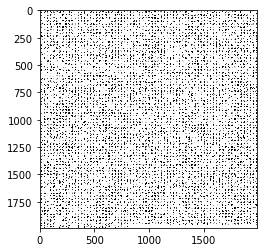

In [8]:
to_visualise = batch_xs
to_visualise = vector_to_matrix_mnist(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

plt.imsave(path_for_mnist_sprites,sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')

### Save the metadata
To add colors to your mnist digits the embedding visualisation tool needs to know what label each image has. This is saved in a "TSV (tab seperated file)". 

Each line of our file contains the following: 

    "Index" , "Label" 

The Index is simply the index in our embedding matrix. The label is the label of the MNIST character. 

This code writes our data to the metadata file. 

In [9]:
path_for_mnist_metadata

'C:\\Users\\Chris.Cui\\Documents\\PythonScripts\\Simplest-Tensorflow-Tensorboard-MNIST-Embedding-Visualisation-master\\minimalsample\\metadata.tsv'

In [10]:
with open(path_for_mnist_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(batch_ys):
        f.write("%d\t%d\n" % (index,label))

### How to run (https://imgur.com/a/4EFGZ)
We saved our MNIST characters, time to visualise it! If you did not change any of the variables above you can run the visualisation with: 

tensorboard --logdir=minimalsample

Now open a browser and navigate to http://127.0.0.1:6006 (note: this can change depending on your computer setup). You should see this after navigating to the Embeddings tab (note: if you have an older tensorflow version you will NOT see the Embeddings tab. This can only be resolved by upgradeing Tensorflow): 

![Imgur](http://i.imgur.com/THBeQwR.png)

Click the embeddings tab to see the PCA of our MNIST digits. Click on the left on the "color by" selector and select the Label. You probably see some nice groupings (zeroes close to each other, sixes close to each other, etc.). 

![Imgur](http://i.imgur.com/5Qjjnt4.png)
You can also try T-SNE to see the digits move around while they are trying to form groups. 
![Imgur](http://i.imgur.com/kIQ8juH.png)



# Conclusion

Hopefully you now see that it is easy to add an embedding visualisation to your algorithm. Good luck visualising your own!